In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')
import jax


In [2]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/dr17_dr3_McMillan_astroNN_rev1.fits'
tb = fits.open(path)
data = tb[1].data 

In [3]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_members_VAC.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7260 GC stars


In [4]:
apo_id = data['APOGEE_ID_1']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [54]:
import galpy
from galpy.util import bovy_coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
from astropy.io import fits
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.bovy_conversion import get_physical
from galpy.actionAngle import UnboundError


In [55]:
def dat_to_galcen(dat,
                  return_rphiz =True,
                  verbose =False,
                  ro = 8.275,  # GRAVITY 2018 value 
                  vo = 220.,   # GRAVITY 2018 value 
                  zo = 0.02,    # Bennet and Bovy 2018 value
                  keys = ['RA', 'DEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'pmra', 'pmdec', 'VHELIO_AVG'],
                  #cov_keys = [dat['pmra_error_1'],dat['pmdec_error_1'],dat['SH_weighted_diststd'],dat['VERR_1']],
                  parallax = False):
    vxvv = np.dstack([dat[keys[i]] for i in range(len(keys))])[0]
    ra, dec= vxvv[:,0], vxvv[:,1]
    lb= bovy_coords.radec_to_lb(ra,dec,degree=True, epoch=None)
    pmra, pmdec= vxvv[:,3], vxvv[:,4]
    pmllpmbb= bovy_coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
    d, vlos= vxvv[:,2]/1e3, vxvv[:,5]
    if parallax:
        d = 1./d
    rectgal= bovy_coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
    vsolar= np.array([-11.1,26.5,7.25]) # Values from Ted's halo paper, taken from Schrondich 2010 and adjusted given by the proper motion values for SGR A* by the GRAVITY collaboration. Vx is negative because we adopt the x convention to go in opposite direction
    vsun= np.array([0.,1.,0.,])+vsolar/vo
    X = rectgal[:,0]/ro
    Y = rectgal[:,1]/ro
    Z = rectgal[:,2]/ro
    vx = rectgal[:,3]/vo
    vy = rectgal[:,4]/vo
    vz = rectgal[:,5]/vo
    XYZ = np.dstack([X, Y, Z])[0]
    vxyz = np.dstack([vx,vy,vz])[0]
    Rpz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
    vRvTvz = bovy_coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                                    vsun=vsun,
                                                                    Xsun=1.,
                                                                    Zsun=zo/ro,
                                                                    galcen=True)
    return XYZ, vxyz, Rpz, vRvTvz

In [56]:
xyz,vxyz,Rpz,vRvTvz = dat_to_galcen(data)

In [57]:
rgal = Rpz[:,0]*8.275
zgal = Rpz[:,2]*8.275

rads = np.sqrt(rgal**2+zgal**2)

(array([8.06670e+04, 5.96229e+05, 3.47580e+04, 5.79100e+03, 1.79400e+03,
        5.36000e+02, 1.75000e+02, 3.80000e+01, 2.00000e+01, 2.00000e+00]),
 array([ 0.10396658,  6.11152052, 12.11907446, 18.1266284 , 24.13418234,
        30.14173628, 36.14929022, 42.15684416, 48.1643981 , 54.17195203,
        60.17950597]),
 <BarContainer object of 10 artists>)

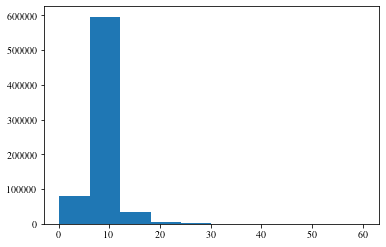

In [58]:
plt.hist(rads)

In [59]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

683198

In [60]:
aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

691590

(0.0, 100.0)

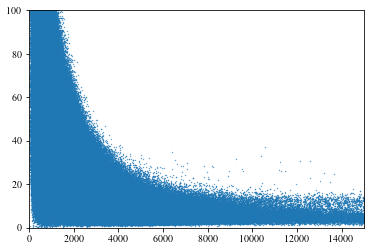

In [61]:
dist_err = (data['GAIAEDR3_R_HI_PHOTOGEO']-data['GAIAEDR3_R_LO_PHOTOGEO'])/2.
plt.scatter(data['GAIAEDR3_R_MED_PHOTOGEO'],data['GAIAEDR3_R_MED_PHOTOGEO']/dist_err,s=0.1)
plt.xlim(0,15000)
plt.ylim(0,100)

In [82]:
dist_err = (data['GAIAEDR3_R_HI_PHOTOGEO']-data['GAIAEDR3_R_LO_PHOTOGEO'])/2.
mask_solar = (data['SNR']>50)&(data['LOGG']<3.)&(data['LOGG']>0.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(data['GAIAEDR3_R_MED_PHOTOGEO']/dist_err>5)&(mask_gcs==False) & (mask_gcs2==False)\
    &(data['GAIAEDR3_R_MED_PHOTOGEO']<2000)&(data['LOGG_ERR']<0.2)&(starflag_mask)&(aspcapflag_mask)&(data['EXTRATARG']==0)


In [83]:
np.save('/Users/dhortadarrington/Documents/Projects/mw-bar/sav/mask_solar',mask_solar)

In [78]:
# new less restrictive sample selection
dist_err = (data['GAIAEDR3_R_HI_PHOTOGEO']-data['GAIAEDR3_R_LO_PHOTOGEO'])/2.
mask = (data['SNR']>50)&(data['LOGG']<3.)&(data['LOGG']>0.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(data['GAIAEDR3_R_MED_PHOTOGEO']/dist_err>5)&(mask_gcs==False) & (mask_gcs2==False)\
    &(rads<5)&(data['LOGG_ERR']<0.2)&(starflag_mask)&(aspcapflag_mask)&(data['EXTRATARG']==0)

# print('There are '+str(len(data[mask]))+' stars in the parent sample')

# np.savetxt('/Users/dhortadarrington/Desktop/new_inner_gal_sample',data['APOGEE_ID_1'][mask],fmt='%s')

In [79]:
mask_unique = np.isin(data['APOGEE_ID_1'],np.unique(data['APOGEE_ID_1']))
print(len(data[mask&mask_unique]))

21742


In [72]:
print(len(data[mask]))
print(len(data[mask&(data['FE_H']>-0.8)]))

21742
18933


Text(0, 0.5, '[Mg/Fe]')

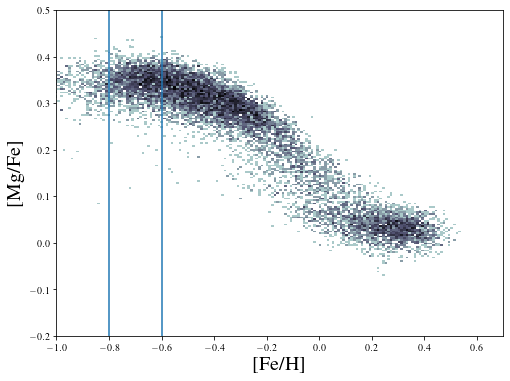

In [73]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6),facecolor='white')
mask_plot = (data['FE_H']>-10)&(data['MG_FE']>-10)
plt.hist2d(data['FE_H'][mask&mask_plot],data['MG_FE'][mask&mask_plot],bins=300,cmap='bone_r',norm=LogNorm())
plt.vlines(-0.8,-0.2,0.5)
plt.vlines(-0.6,-0.2,0.5)
plt.xlim(-1,0.7)
plt.ylim(-0.2,0.5)
plt.xlabel('[Fe/H]',fontsize=20)
plt.ylabel('[Mg/Fe]',fontsize=20)


Text(0, 0.5, '[Mg/Fe]')

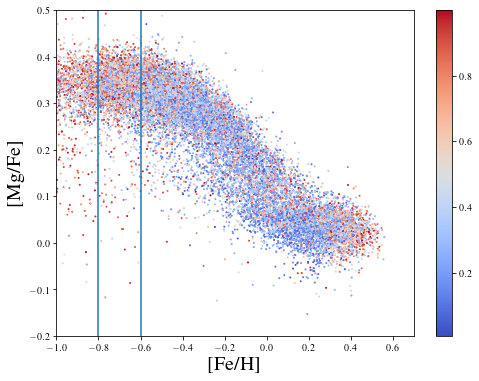

In [74]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6),facecolor='white')
mask_plot = (data['FE_H']>-10)&(data['MG_FE']>-10)&(data['ecc']>0)
plt.scatter(data['FE_H'][mask&mask_plot],data['MG_FE'][mask&mask_plot],c=data['ecc'][mask&mask_plot],s=1,cmap='coolwarm')
plt.colorbar()
plt.vlines(-0.8,-0.2,0.5)
plt.vlines(-0.6,-0.2,0.5)
plt.xlim(-1,0.7)
plt.ylim(-0.2,0.5)
plt.xlabel('[Fe/H]',fontsize=20)
plt.ylabel('[Mg/Fe]',fontsize=20)


(array([  2.,   0.,   1.,   1.,   2.,   1.,   1.,   1.,   3.,   3.,   4.,
          7.,   6.,   5.,   2.,  14.,   4.,   2.,  12.,   7.,   8.,  11.,
         15.,  14.,  24.,  12.,  17.,  25.,  19.,  28.,  23.,  37.,  29.,
         33.,  52.,  52.,  52.,  69.,  67.,  65.,  79., 104.,  83.,  84.,
        111., 102., 120., 124., 150., 134., 136., 164., 193., 247., 253.,
        318., 373., 491., 496., 582., 595., 587., 659., 617., 666., 659.,
        668., 641., 610., 641., 634., 598., 535., 528., 467., 405., 375.,
        379., 370., 340., 320., 313., 336., 313., 307., 330., 342., 331.,
        406., 368., 399., 426., 371., 351., 284., 195., 112.,  65.,  32.,
         10.]),
 array([-2.4532    , -2.4230607 , -2.3929212 , -2.3627815 , -2.332642  ,
        -2.3025026 , -2.2723632 , -2.2422235 , -2.212084  , -2.1819446 ,
        -2.1518052 , -2.1216655 , -2.091526  , -2.0613866 , -2.0312471 ,
        -2.0011077 , -1.9709681 , -1.9408286 , -1.9106891 , -1.8805496 ,
        -1.8504101 , -1.82

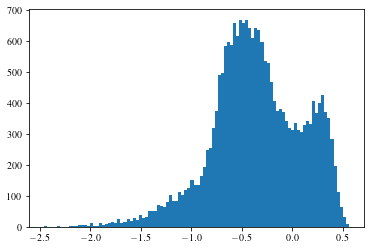

In [75]:
plt.hist(data['FE_H'][mask&mask_plot],100)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([3500.02636719, 3506.44411458, 3512.86186198, 3519.27960937,
        3525.69735677, 3532.11510417, 3538.53285156, 3544.95059896,
        3551.36834635, 3557.78609375, 3564.20384115, 3570.62158854,
        3577.03933594, 3583.45708333, 3589.87483073, 3596.29257813,
        3602.71032552, 3609.12807292, 3615.54582031, 3621.96356771,
        3628.3813151 , 3634.7990625 , 3641.2168099 , 3647.63455729,
        3654.05230469, 3660.47005208, 3666.88779948, 3673.30554687,
        3679.72329427, 3686.14104167, 3692.55878906, 3698.97653646,
        3705.39428385, 3711.81203125, 3718.22977865, 3724.64752604,
        3731.06527344, 3737.48302083, 3743.90076823, 3750.31851563,
        3756.73626302, 3763.15401042, 3769.57175781, 3775.98950521,
   

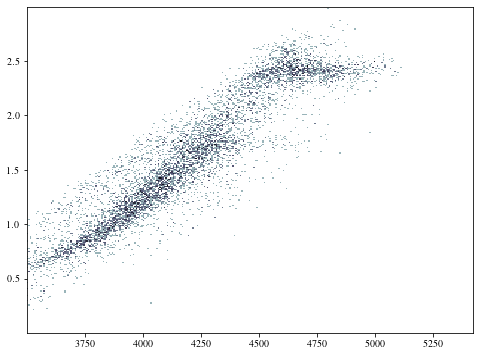

In [76]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6),facecolor='white')
mask_plot = (data['LOGG']>-10)&(data['TEFF']>-10)
plt.hist2d(data['TEFF'][mask&mask_plot],data['LOGG'][mask&mask_plot],bins=300,cmap='bone_r',norm=LogNorm())
# plt.vlines(-0.8,-0.2,0.5)
# plt.vlines(-0.6,-0.2,0.5)
# plt.xlim(-1,0.7)
# plt.ylim(-0.2,0.5)

In [77]:
np.savetxt('/Users/dhortadarrington/Desktop/A17G3-innergal',data['APOGEE_ID_1'][mask],fmt='%s')